In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

## Input files
Obsevations: average expression for a leiden cluster (cell type) <br>
Features: 11k genes that overlap across all datsets 

In [50]:
# We first make a scanpy object with the counts we have 
# then we use the scanpy to create a DataLoader
# 
counts = pd.read_csv("../data/integrated_counts/counts_expm1_Feb24.csv", index_col = 0)
meta = pd.read_csv("../data/integrated_counts/meta_data_Feb24.csv", index_col = 0)

counts = counts.T

#scale counts by 10 to increase dynamic range of lowly expressed genes 
# in theory it should not have by contrary effect since we are normamlizing by library size 
#counts = counts.div(1/10)
counts.shape, meta.shape

((1206, 11675), (1206, 10))

In [42]:
counts.head()

,Abi2,Acadl,Actr1b,Adam23,Adhfe1,Aff3,Als2,Ankrd39,Ankrd44,Arfgef1,...,Vldlr,Vps13a,Vti1a,Vwa2,Xpnpep1,Zdhhc16,Zdhhc6,Zfand5,Zfp518a,Zfyve27
1_E6.5_8.5_Chan,0.300056,0.209356,0.556247,0.023802,0.003552,0.054591,0.045868,0.108438,0.007118,0.141504,...,0.034883,0.077727,0.045228,0.015388,0.472990,0.314311,0.549204,0.617297,0.208914,0.055166
2_E6.5_8.5_Chan,0.113394,0.131442,0.388996,0.014259,0.009897,0.028465,0.005029,0.124987,0.000000,0.065782,...,0.004213,0.010186,0.027929,0.003617,0.394133,0.203649,0.348373,0.635299,0.075427,0.020556
3_E6.5_8.5_Chan,0.220663,0.160313,0.513679,0.055661,0.004354,0.056418,0.038450,0.134707,0.011689,0.172516,...,0.027235,0.131581,0.039064,0.030639,0.285376,0.255032,0.518535,0.620260,0.269424,0.056064
4_E6.5_8.5_Chan,0.282691,0.219056,0.563388,0.049449,0.003716,0.061247,0.043469,0.178020,0.010452,0.171744,...,0.004464,0.076030,0.030168,0.019030,0.443839,0.306142,0.555976,0.754647,0.180463,0.047292
5_E6.5_8.5_Chan,0.055400,0.188723,0.693724,0.001685,0.001083,0.007624,0.033985,0.147624,0.001150,0.233223,...,0.018612,0.067952,0.080168,0.001150,0.847592,0.315743,0.560970,0.596525,0.107739,0.054099


In [40]:
meta['total_counts'] = np.sum(counts, axis = 1)
meta.head() 

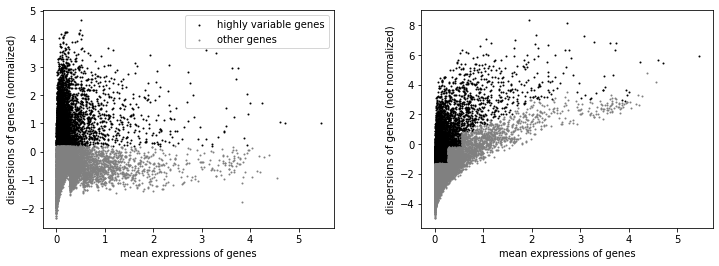

<ipython-input-63-00dc52280b5a>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_genes[['Bmpr1a', 'Acvrl1','Acvr1', 'Bmpr1b','Acvr2b', 'Bmpr2', 'Acvr2a']] = True
/home/agranado/anaconda3/envs/singlecell/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [63]:
#normalize
# create the adata object from the count matrix 
adata = ad.AnnData(X = counts, obs = meta)
adata.obs.reset_index(inplace = True)


sc.pp.normalize_total(adata, target_sum=10000)

sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, 
                            min_mean=0.01, max_mean=3, 
                            min_disp=0.3, n_top_genes = 4000)

sc.pl.highly_variable_genes(adata)

### 


joint_genes = adata.var.highly_variable
# Add genes of interest to the list of highly variable
# This way we keep them for the downstream analaysis 
joint_genes[['Bmpr1a', 'Acvrl1','Acvr1', 'Bmpr1b','Acvr2b', 'Bmpr2', 'Acvr2a']] = True

adata.raw = adata
adata = adata[:, joint_genes]

In [62]:
#sc.pp.regress_out(adata, ['dataset'])


... storing 'Tissue_old' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'age' as categorical
... storing 'dataset' as categorical
... storing 'Cell_class' as categorical
... storing 'Tissue' as categorical
... storing 'data_batch' as categorical


## Look at the distributions of normalized counts before scaling

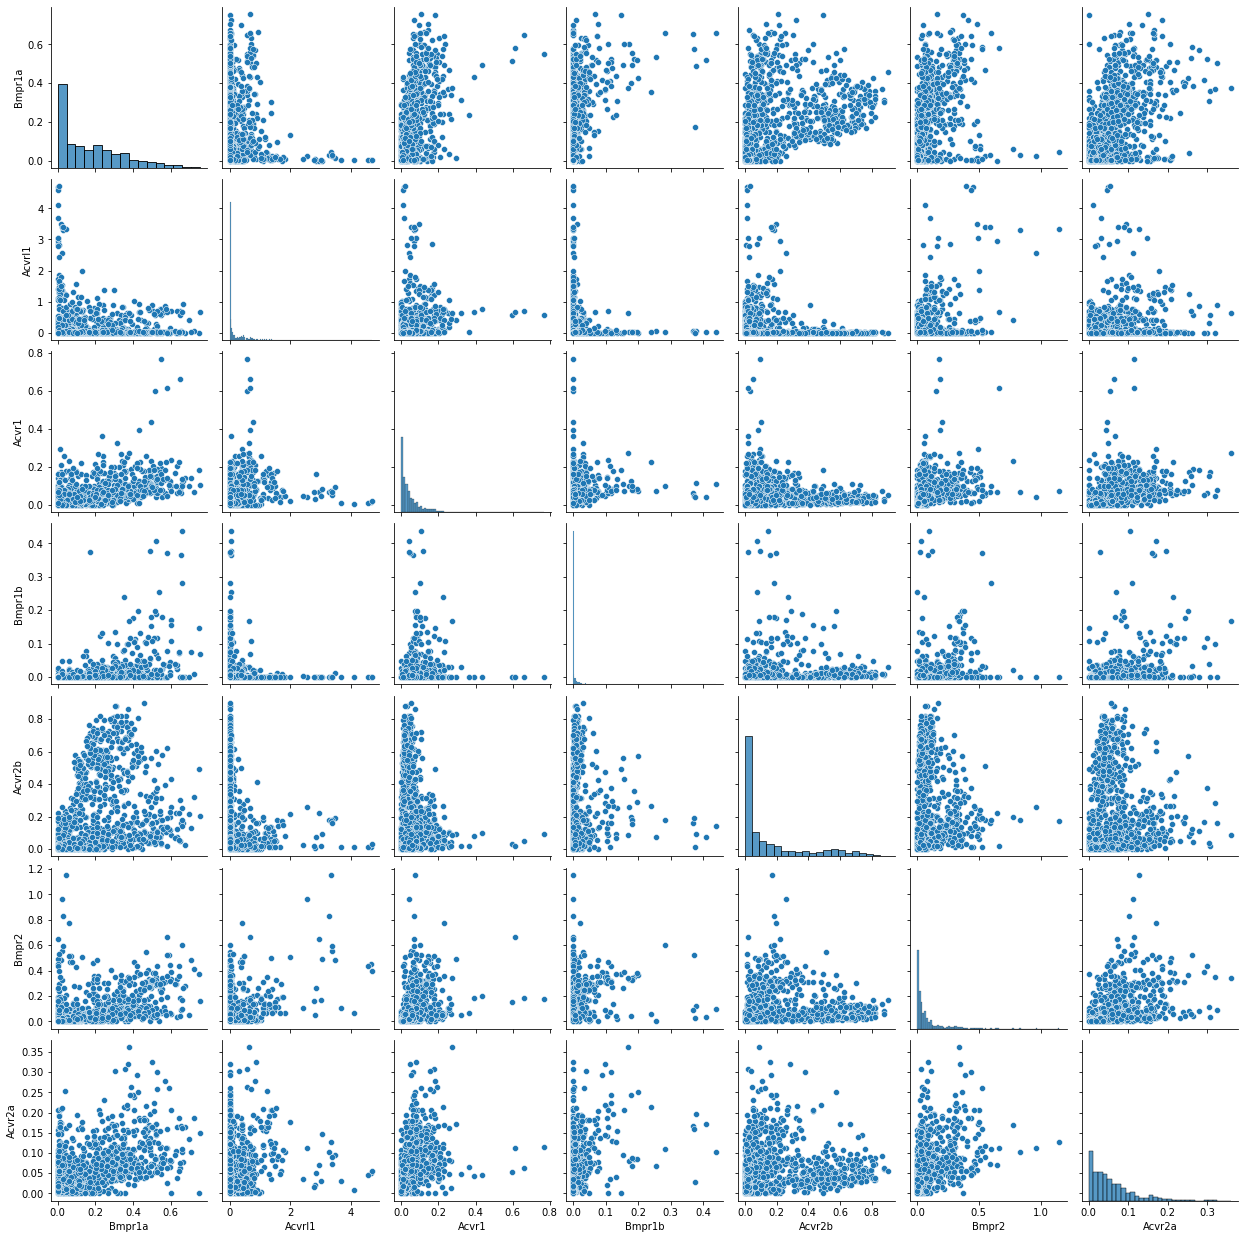

In [64]:
from mlxtend.plotting import scatterplotmatrix
import seaborn as sns

bmp_receptors = ['Bmpr1a', 'Acvrl1','Acvr1', 'Bmpr1b','Acvr2b', 'Bmpr2', 'Acvr2a']

signaling_counts = adata[:,bmp_receptors].X
df = pd.DataFrame(signaling_counts,columns = bmp_receptors)
sns.pairplot(df)


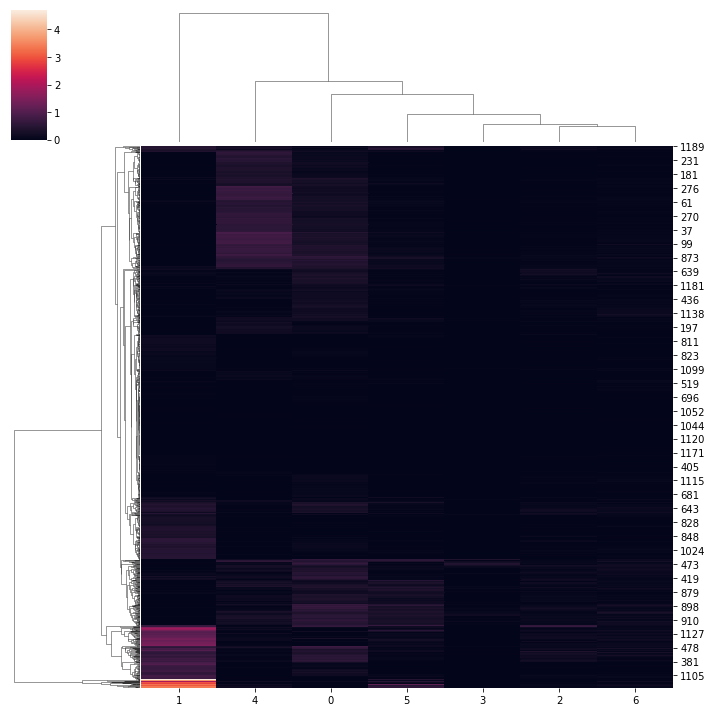

In [65]:
sns.clustermap(adata[:,bmp_receptors].X)

In [66]:
sc.pp.scale(adata, max_value=10)


/home/agranado/anaconda3/envs/singlecell/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/agranado/anaconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [67]:
sc.tl.pca(adata, svd_solver='arpack', n_comps = 100)


... storing 'Tissue_old' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'age' as categorical
... storing 'dataset' as categorical
... storing 'Cell_class' as categorical
... storing 'Tissue' as categorical
... storing 'data_batch' as categorical


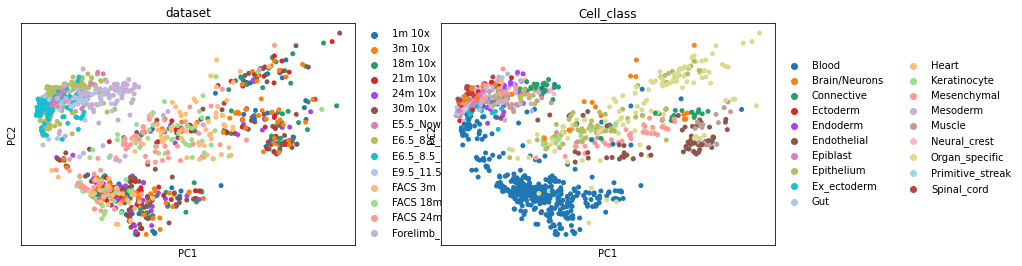

In [68]:
sc.pl.pca(adata, color=['dataset','Cell_class'])


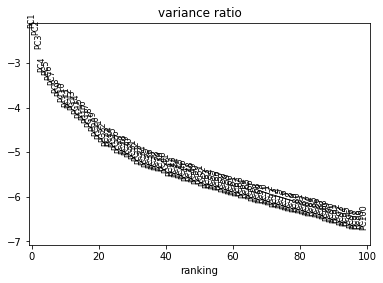

In [69]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 100)


In [70]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=80)


In [71]:
sc.tl.umap(adata)

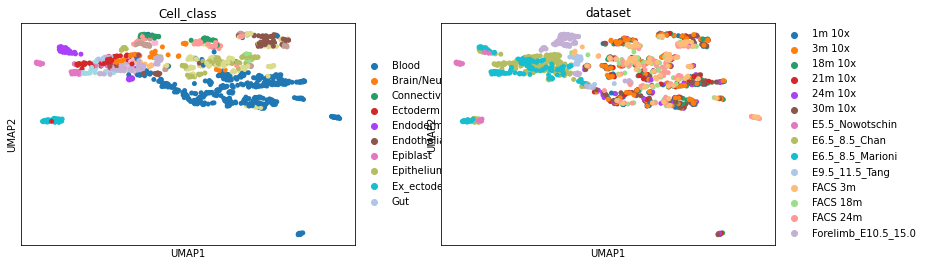

In [72]:
sc.pl.umap(adata, color = ['Cell_class','dataset'], use_raw = False)

In [73]:
sc.external.pp.bbknn(adata, batch_key = 'dataset', n_pcs = 70)

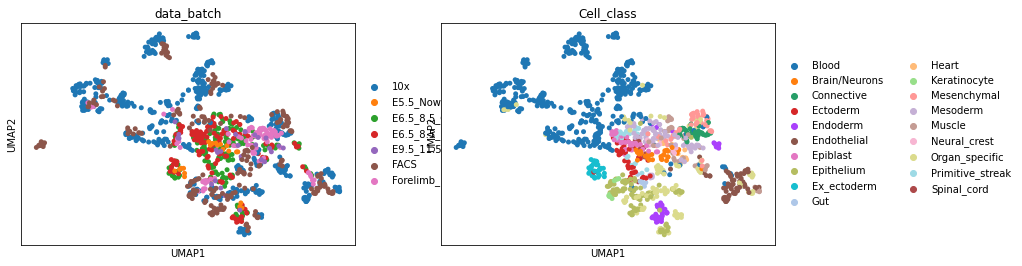

In [91]:
sc.tl.umap(adata) # after batch correction 
sc.pl.umap(adata, color =["data_batch","Cell_class"])

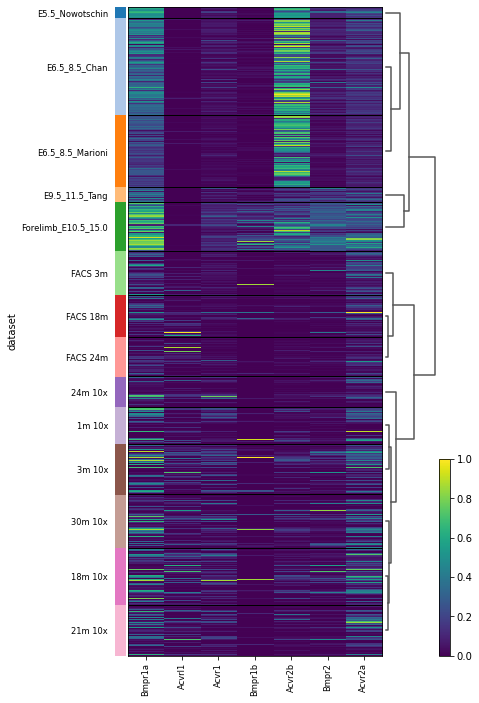

In [75]:
bmp_receptors = ['Bmpr1a', 'Acvrl1','Acvr1', 'Bmpr1b','Acvr2b', 'Bmpr2', 'Acvr2a']
sc.pl.heatmap(adata, bmp_receptors, groupby = ['dataset'], 
              dendrogram = True, figsize = [6,12], 
             standard_scale = 'var')

/home/agranado/anaconda3/envs/singlecell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


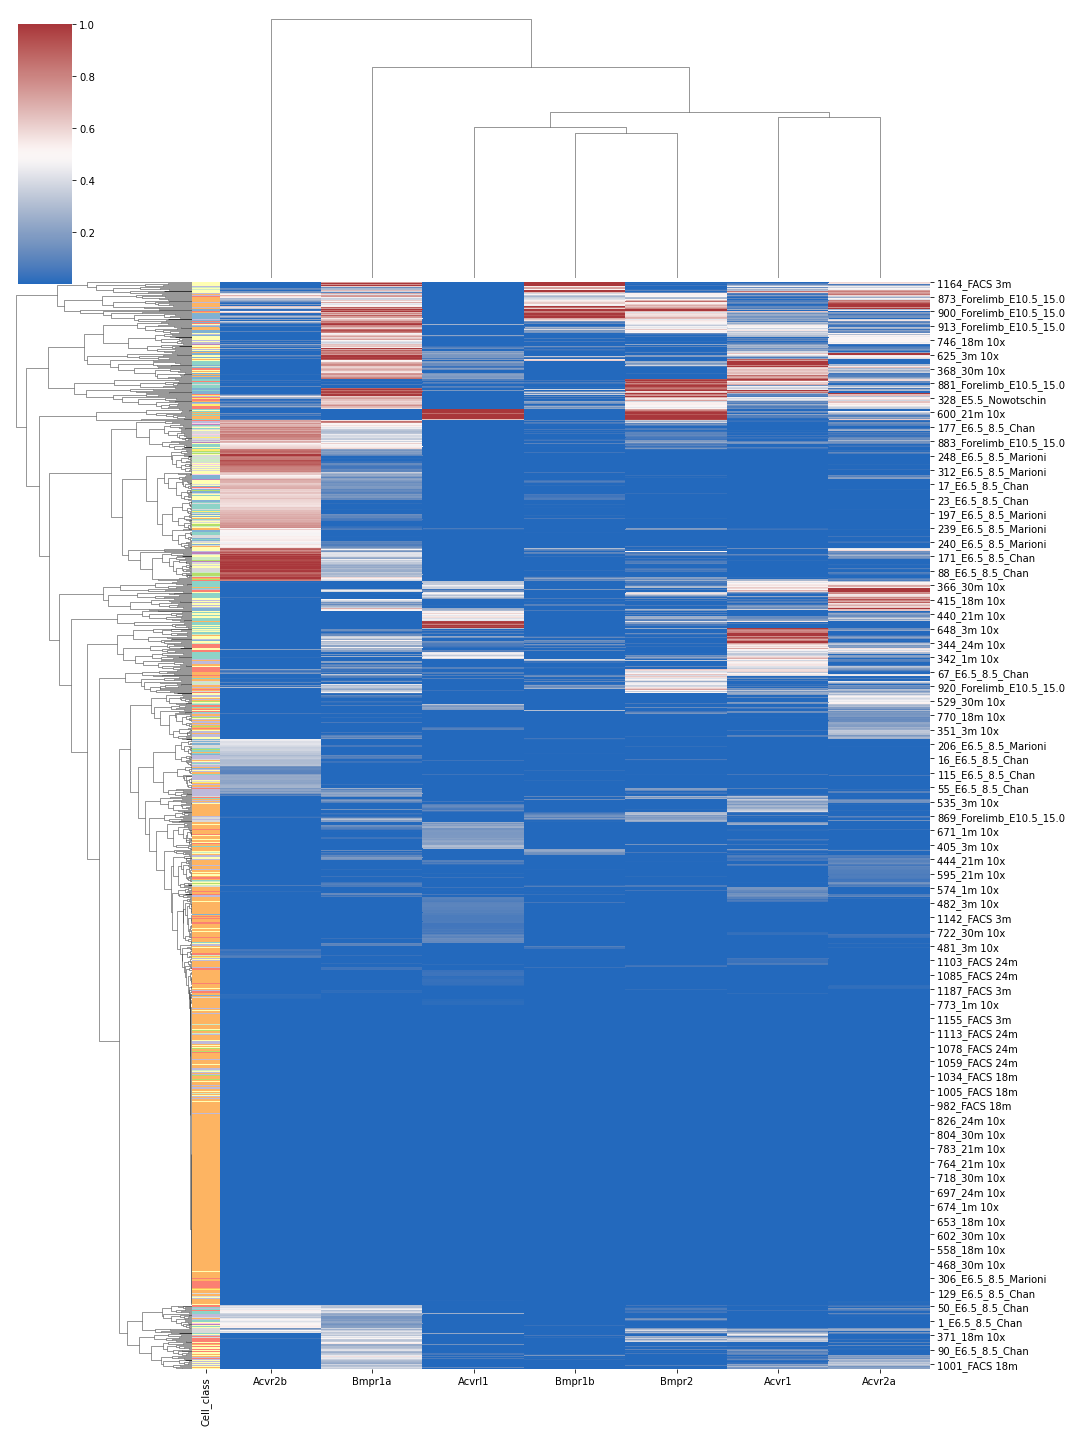

In [78]:
annotatedHeatmap(adata, bmp_receptors, ann_var = 'Cell_class', dist_metric = 'euclidean')

## mnn.correct 
The mnn_correct function returns a tuple with the AnnData object, list of cell pairs and of angles.Hence, cdata[0] is the new AnnData object.
We get corrected expression values for all genes even though only the selected genes were used for finding neighbor cells



In [92]:
# run the adata from scratch 
# commands from here: https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_03_integration.html
#normalize
# create the adata object from the count matrix 
adata_mnn = ad.AnnData(X = counts, obs = meta)
adata_mnn.obs.reset_index(inplace = True)


sc.pp.normalize_total(adata_mnn, target_sum=10000)

sc.pp.log1p(adata_mnn)

sc.pp.highly_variable_genes(adata_mnn, 
                            min_mean=0.01, max_mean=3, 
                            min_disp=0.3, n_top_genes = 4000)

#sc.pl.highly_variable_genes(adata)
var_genes = adata_mnn.var.highly_variable
var_genes[['Bmpr1a', 'Acvrl1','Acvr1', 'Bmpr1b','Acvr2b', 'Bmpr2', 'Acvr2a']] = True


# batch correction 
cdata = sc.external.pp.mnn_correct(adata_mnn, var_subset = var_genes, 
                                   svd_dim = 100, batch_key ='data_batch', save_raw = True)


# cdata[0] is still a tuple for some reason (as opposed to the tutorial)
corr_data= cdata[0][0][:,var_genes]
corr_data.X.shape

<ipython-input-92-3265efa64cda>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_genes[['Bmpr1a', 'Acvrl1','Acvr1', 'Bmpr1b','Acvr2b', 'Bmpr2', 'Acvr2a']] = True
/home/agranado/anaconda3/envs/singlecell/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


(1206, 4004)

/home/agranado/anaconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'Tissue_old' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'age' as categorical
... storing 'dataset' as categorical
... storing 'Cell_class' as categorical
... storing 'Tissue' as categorical
... storing 'data_batch' as categorical


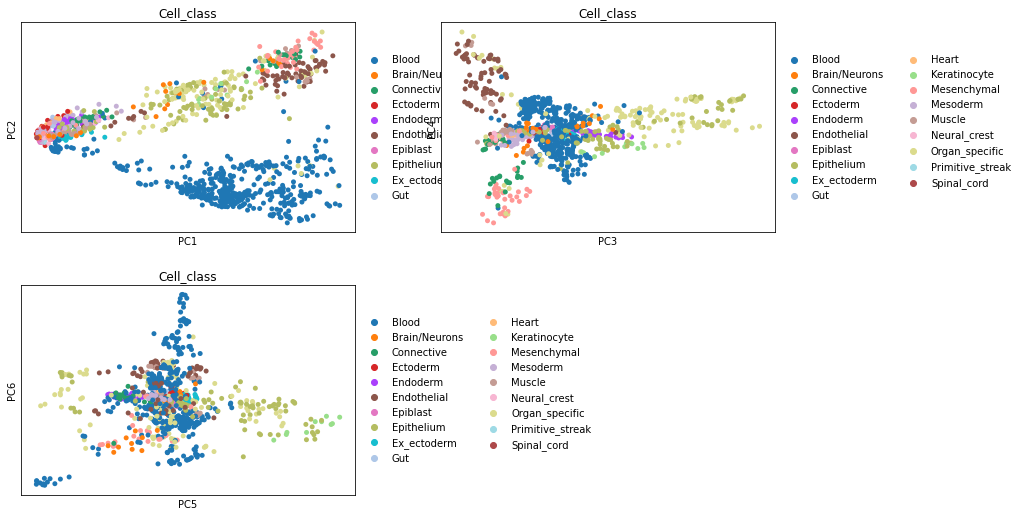

In [93]:
sc.tl.pca(corr_data, svd_solver ='arpack', use_highly_variable = False,n_comps = 100)
sc.pl.pca(corr_data, components = ['1,2','3,4','5,6'], ncols = 2, color = 'Cell_class')

In [94]:
sc.pp.neighbors(corr_data, n_pcs = 70, n_neighbors = 40 )
sc.tl.umap(corr_data)

<AxesSubplot:title={'center':'dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

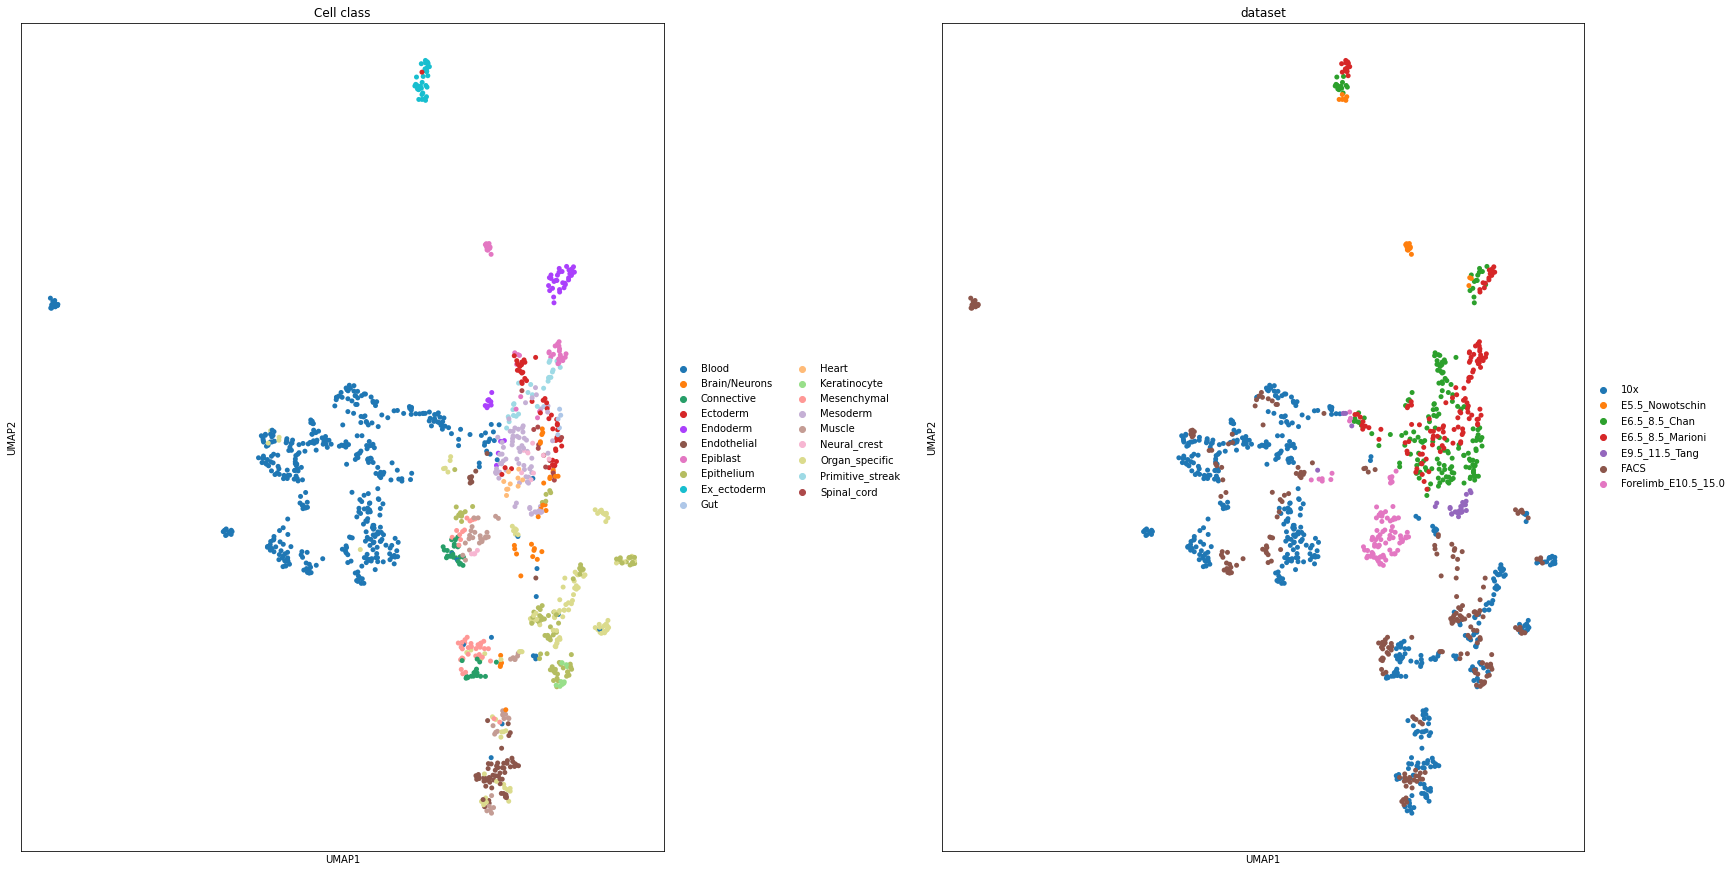

In [98]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2,figsize = (24,12), constrained_layout = True)
sc.pl.umap(corr_data, color="Cell_class", title="Cell class", ax=axs[0], show=False)
sc.pl.umap(corr_data, color="data_batch", title="dataset", ax=axs[1], show=False)

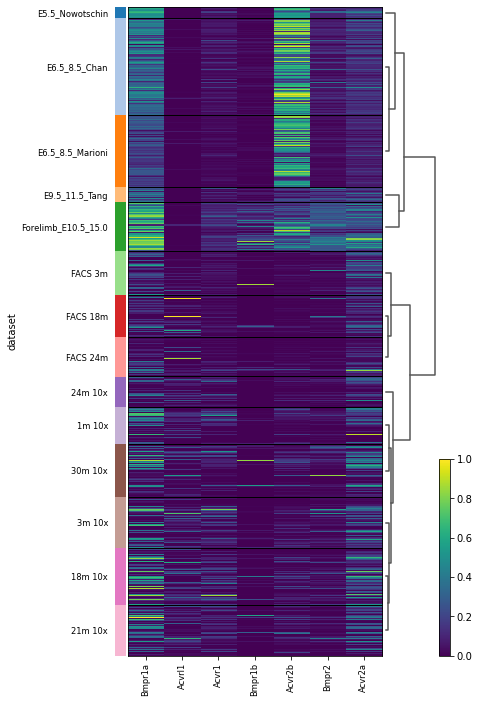

In [99]:
bmp_receptors = ['Bmpr1a', 'Acvrl1','Acvr1', 'Bmpr1b','Acvr2b', 'Bmpr2', 'Acvr2a']


sc.pl.heatmap(corr_data, bmp_receptors, groupby = ['dataset'], 
              dendrogram = True, figsize = [6,12], 
             standard_scale ='var')

/home/agranado/anaconda3/envs/singlecell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


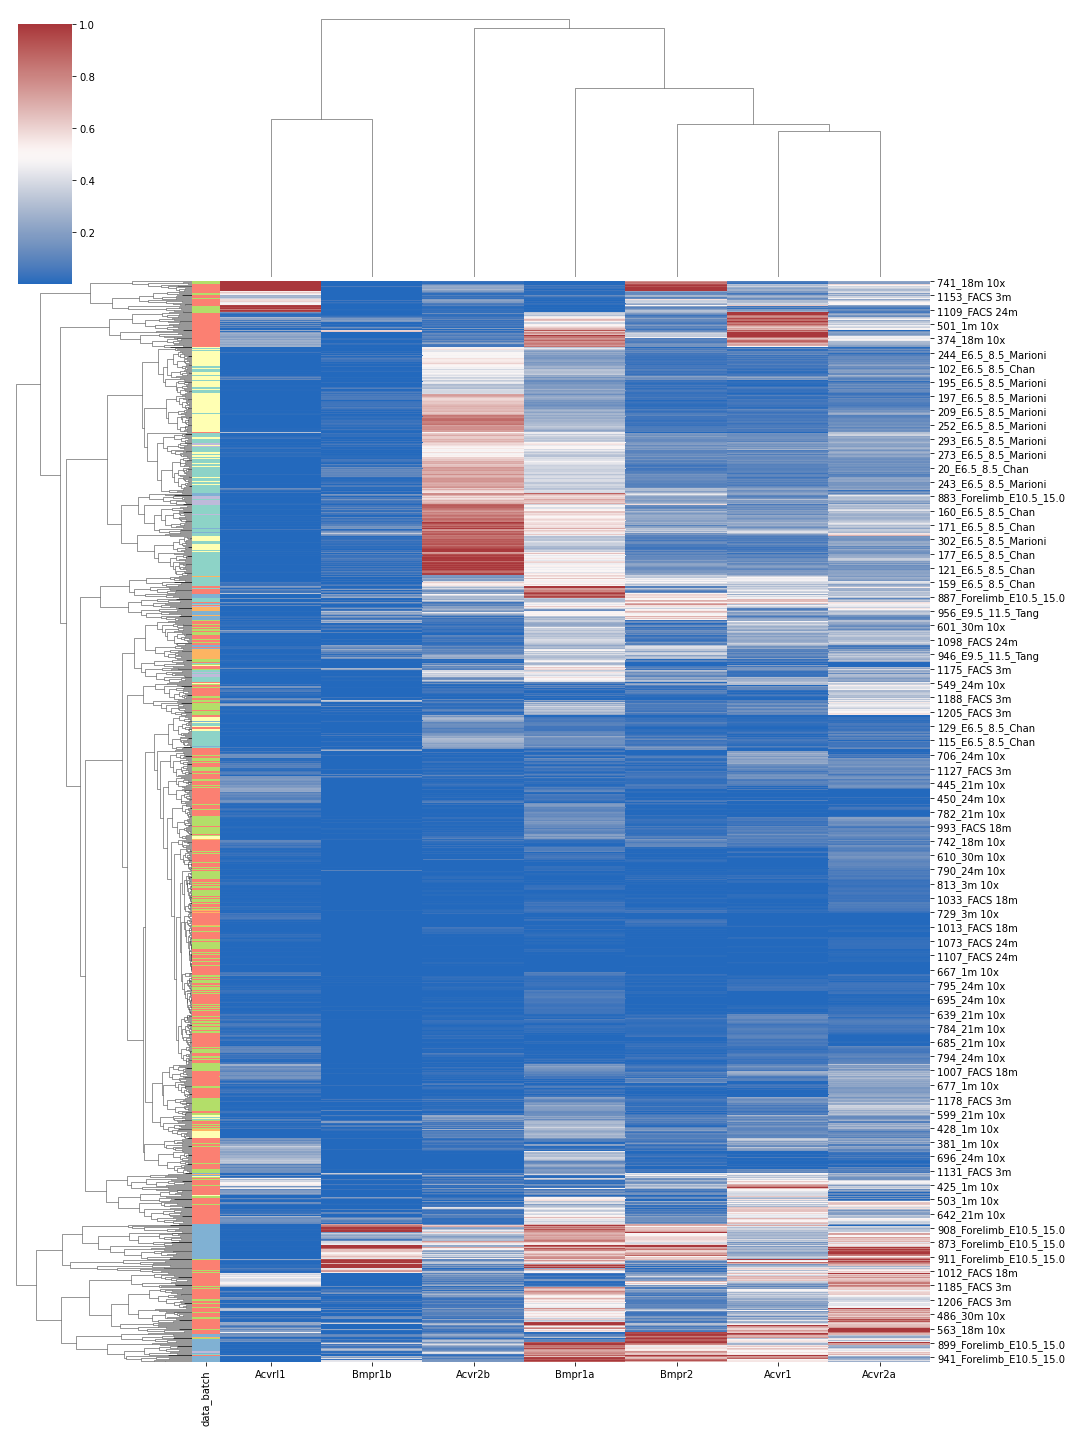

In [100]:
annotatedHeatmap(corr_data, bmp_receptors, ann_var = 'data_batch', dist_metric = 'euclidean')

In [77]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
def annotatedHeatmap(corr_data = [], bmp_receptors = [], ann_var ='dataset', dist_metric = 'euclidean'):
    # For cosine distance we can't have rows with only zero values 
    # so we set an extremely low min value 
    scaler =MinMaxScaler(feature_range= (0.00000001, 1)) 
    # Corrected counts after batch correction 
    counts_receptors = corr_data[:,bmp_receptors].X
    # we are normalizing by a quantile instead of the max to buffer the outliers
    quant_limit = np.quantile(counts_receptors, 0.99,0)
    clipped_counts = np.clip(counts_receptors,a_min = 0, a_max = quant_limit)

    # Color palette based on dataset 
    #ann_var = 'dataset'
    profile_pal = sns.color_palette('Set3', len(meta[ann_var].unique() ))
    profile_lut = dict(zip(meta[ann_var].unique() , profile_pal))
    profile_colors = pd.Series( meta[ann_var].map(profile_lut))

    receptor_data = pd.DataFrame(clipped_counts, columns = bmp_receptors)
    scaled_data = scaler.fit_transform(receptor_data.values)
    scaled_df = pd.DataFrame(scaled_data, columns = bmp_receptors, index = meta.index)
    sns.clustermap(scaled_df, cmap = 'vlag', 
                   method ='complete', metric= dist_metric,
                   row_colors = profile_colors, 
                   rasterized = True, figsize = (15,20))

In [73]:
profile_colors.reset_index(inplace=False)

,index,dataset
0,1_E6.5_8.5_Chan,"(0.5529411764705883, 0.8274509803921568, 0.780..."
1,2_E6.5_8.5_Chan,"(0.5529411764705883, 0.8274509803921568, 0.780..."
2,3_E6.5_8.5_Chan,"(0.5529411764705883, 0.8274509803921568, 0.780..."
3,4_E6.5_8.5_Chan,"(0.5529411764705883, 0.8274509803921568, 0.780..."
4,5_E6.5_8.5_Chan,"(0.5529411764705883, 0.8274509803921568, 0.780..."
...,...,...
1201,1202_FACS 3m,"(1.0, 1.0, 0.7019607843137254)"
1202,1203_FACS 3m,"(1.0, 1.0, 0.7019607843137254)"
1203,1204_FACS 3m,"(1.0, 1.0, 0.7019607843137254)"
1204,1205_FACS 3m,"(1.0, 1.0, 0.7019607843137254)"


In [51]:
np.max(receptor_data, axis = 0)

Bmpr1a    1.357343
Acvrl1    5.004921
Acvr1     2.305598
Bmpr1b    1.910483
Acvr2b    0.959567
Bmpr2     3.781098
Acvr2a    1.003054
dtype: float32

In [16]:
import sys
!{sys.executable} -m pip install bbknn

     |████████████████████████████████| 646 kB 14.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 18.3 MB/s eta 0:00:01
  Created wheel for annoy: filename=annoy-1.17.0-cp38-cp38-linux_x86_64.whl size=577492 sha256=7b3f4584e061523094ad3512ec9b59a18255e91222e663c6d387ec6ac6cfdad5
  Stored in directory: /home/agranado/.cache/pip/wheels/77/01/de/4421524f9997a25dfa7291121565d12ef514154945e80e907a
Successfully built annoy


In [131]:
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge mlxtend


Solving environment: done

## Package Plan ##

  environment location: /home/agranado/anaconda3/envs/singlecell

  added / updated specs:
    - mlxtend


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    mlxtend-0.18.0             |     pyhd3deb0d_0         1.2 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.2 MB

The following NEW packages will be INSTALLED:

  mlxtend            conda-forge/noarch::mlxtend-0.18.0-pyhd3deb0d_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2021.1.19-~ --> conda-forge::ca-certificates-2020.12.5-ha878542_0
  openssl              pkgs/main::openssl-1.1.1j-h27cfd23_0 --> conda-forge::openssl-1.1.1j-h7f98852_0



mlxtend-0.18.0       | 1.2 MB    | ##################################### | 100% 
Pr